In [58]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import pairwise_distances, silhouette_samples, silhouette_score
from sklearn.cluster import KMeans
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

# Loading data into pandas

In [28]:
## get tweets from our repo
data = pd.read_csv(r"../inputdata/cnnhealth.txt", sep="|", header=None, on_bad_lines='skip')

In [29]:
print("Data in its unedited state: ")
print(data)

Data in its unedited state: 
                       0                               1  \
0     576880531301801984  Sat Mar 14 23:00:11 +0000 2015   
1     576820122666471424  Sat Mar 14 19:00:08 +0000 2015   
2     576744652717461504  Sat Mar 14 14:00:15 +0000 2015   
3     576736754436304896  Sat Mar 14 13:28:52 +0000 2015   
4     576736614766010368  Sat Mar 14 13:28:18 +0000 2015   
...                  ...                             ...   
4040  239699936671854593  Sun Aug 26 12:24:52 +0000 2012   
4041  239504620710420480  Sat Aug 25 23:28:46 +0000 2012   
4042  239410205757145088  Sat Aug 25 17:13:35 +0000 2012   
4043  239386320416428032  Sat Aug 25 15:38:41 +0000 2012   
4044  239366825018806272  Sat Aug 25 14:21:12 +0000 2012   

                                                      2  
0     An abundance of online info can turn us into e...  
1     A plant-based diet that incorporates fish may ...  
2     It doesn't take much to damage your hearing at...  
3     RT @CNN: For

In [30]:
## Removing urls from our tweets. One potential way to remove non-meaningful information such as server locations from the url
## path. Another potential method could be adding appearance thresholds for certain words i.e. if B8VAgxHCYAETD6L.jpg does not
## appear more than once, then remove it from our pool. There may be some meaningful information lost when removing the
## url. Nearly all tweets have embedded links for cnn.com, so keeping those will not help us better classify/differentiate the
## tweets. However, some are for pbs, instagram, etc. so could prove meaningful as a differentiator for clustering.
data[2] = data[2].replace('(https?:\/\/)(?:([^\n ]*))?', '', regex=True)

In [31]:
## Take tweets column from dataframa and convert it to an array so we can preform vector operations on it
tweets = data[2].to_numpy()

In [32]:
print(tweets)

['An abundance of online info can turn us into e-hypochondriacs. Or, worse, lead us to neglect getting the care we need '
 'A plant-based diet that incorporates fish may be the key to preventing colorectal cancers:  '
 "It doesn't take much to damage your hearing at a sports bar or nightclub. That's why a billion people are at risk. "
 ... 'Ann Romney talks about her experience with MS '
 "Make sure your first marathon isn't your last! "
 "Robin Roberts' cancer diagnosis "]


In [37]:
## Create tfid vectorizer, passing the standard english stop words set as a parameter (removes words such as 'and', 'it' and punctuation, etc.)
## we also set the max document frequency to 50% (if a word appears in more than 50% of documents, we want to ignore it)
## set min document frequency to 5 (if a word does not appear in at least 5 tweets, we disregard it)
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.5, min_df=5)

In [123]:
vectorizer.fit(tweets)

TfidfVectorizer(max_df=0.5, min_df=5, stop_words='english')

In [124]:
## get array of unique words across all documents
names = vectorizer.get_feature_names_out()
## for older version of sklearn
# names = vectorizer.get_feature_names()

In [125]:
features = vectorizer.fit_transform(tweets)
features

<4045x1311 sparse matrix of type '<class 'numpy.float64'>'
	with 21338 stored elements in Compressed Sparse Row format>

In [126]:
num_tweets = len(tweets)
num_unique_words = len(names)
avg_words_per_tweet = features.sum() / num_tweets

print(f"Number of tweets: {num_tweets}")
print(f"Number of unique words: {num_unique_words}")
print(f"Average words per tweet: {avg_words_per_tweet}")

Number of tweets: 4045
Number of unique words: 1311
Average words per tweet: 2.1834310748600383


In [127]:
tweetVectors = features.toarray()

In [128]:
print(tweetVectors)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [129]:
tweetVectorDataFrame = pd.DataFrame(tweetVectors, columns=names);

In [130]:
tweetVectorDataFrame.to_csv(r'../outputdata/featurematrix.csv', index=None)

# Calculating Distance Measures

## Cosine similarity measure

In [131]:
cosine_similarity = 1-pairwise_distances(tweetVectors, metric="cosine")
cosine_similarity

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [132]:
cosineSimilarityDf = pd.DataFrame(cosine_similarity);
cosineSimilarityDf.to_csv(r'../outputdata/cosinesimilarity.csv', index=None, header=None)

### Jaccard Similarity measure

In [133]:
from sklearn.metrics import jaccard_score

# Calculate pairwise Jaccard similarities
jaccard_similarities = 1 - pairwise_distances(tweetVectors, metric='jaccard')
jaccard_similarities

C:\Python311\Lib\site-packages\sklearn\metrics\pairwise.py:2025: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [134]:
jaccardSimilarityDf = pd.DataFrame(jaccard_similarities)
jaccardSimilarityDf.to_csv(r'../outputdata/jaccard_similarities.csv', index=None, header=None)

## Visualizing the distance distributions

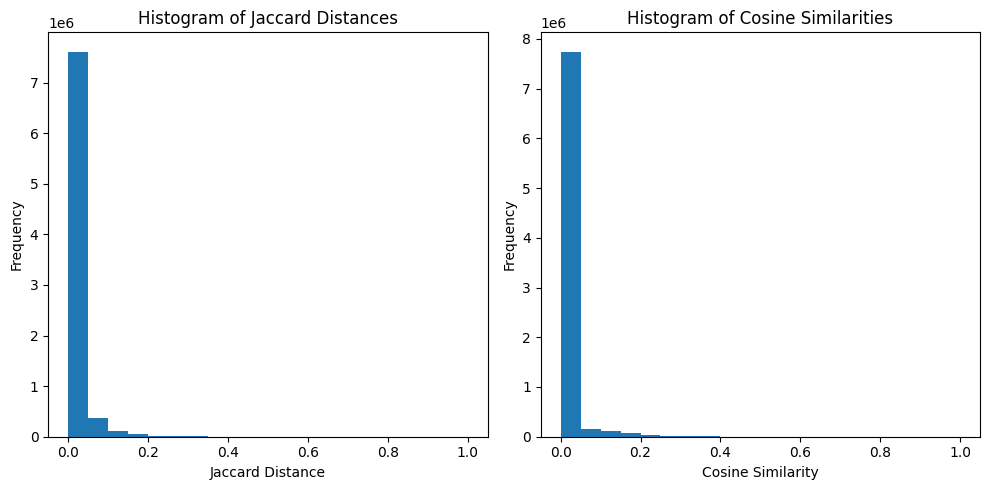

In [135]:
# Flatten the distance matrices and remove self-distances (i.e., distance of a tweet to itself)
jaccard_similarities_flat = jaccard_similarities[np.triu_indices(num_tweets, k=1)]
cosine_similarities_flat = cosine_similarity[np.triu_indices(num_tweets, k=1)]

# Plot the histograms
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(jaccard_similarities_flat, bins=20)
plt.xlabel('Jaccard Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Jaccard Distances')

plt.subplot(1, 2, 2)
plt.hist(cosine_similarities_flat, bins=20)
plt.xlabel('Cosine Similarity')
plt.ylabel('Frequency')
plt.title('Histogram of Cosine Similarities')

plt.tight_layout()
plt.show()

In [136]:
from sklearn.cluster import DBSCAN
# Set the parameters for DBSCAN clustering
eps = 0.3
min_samples = 5

# Create a DBSCAN clustering instance with the Jaccard distance matrix
dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed')

# Fit the DBSCAN instance to the Jaccard distance matrix
dbscan.fit(jaccard_similarities)

DBSCAN(eps=0.3, metric='precomputed')

In [137]:
cluster_labels = dbscan.labels_
cluster_labels
len(set(cluster_labels))

1

In [138]:
from sklearn.manifold import TSNE

In [139]:
# Assuming 'word_freq_matrix' is already created
binary_matrix = (features > 0).astype(int)
dense_binary_matrix = binary_matrix.toarray()

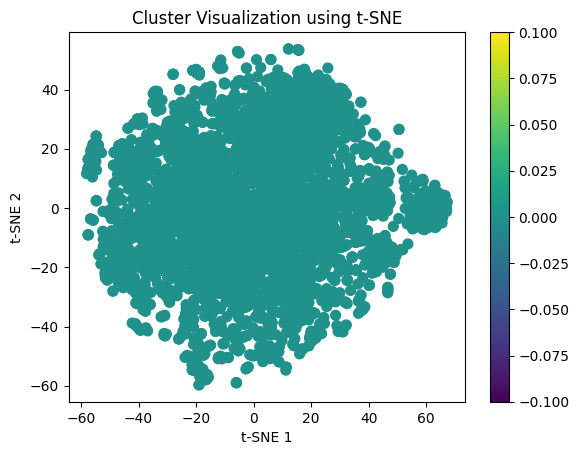

In [140]:
# dense_binary_matrix = binary_matrix.toarray()

tsne = TSNE(n_components=2, metric='cosine', random_state=42, init='random')
reduced_data = tsne.fit_transform(dense_binary_matrix)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap='viridis', marker='o', s=50)
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Cluster Visualization using t-SNE')
plt.colorbar()
plt.show()

## K-Means Clustering with the Cosine Similarity Matrix

In [141]:
kmeans = KMeans()

In [155]:
inertia = []

for i in range(200, 201):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(cosine_similarity)
    inertia.append(kmeans.inertia_)

C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [157]:
print(inertia)

[15166.545940645805]


In [142]:
kmeans = KMeans(n_clusters=5)
kmeans.fit(cosine_similarity)

C:\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5)

In [144]:
cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
print(cluster_sizes)

[ 237  559  173 2909  167]
